# 2012美国总统竞选赞助数据分析

                               ——Meu培训实例1|小子令狐冲出品

<img src="2012.jpg">

In [8]:
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

In [10]:
#读入数据
fec = pd.read_csv('P00000001-ALL.csv')
#因为列'contbr_zip'既有文本也有数字容易造成类型混乱，因此可直接以文本读入
#fec = pd.read_csv('P00000001-ALL.csv',dtype={'contbr_zip':str})

D:\SOFTWARE\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
fec.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.24548e+08,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.19016e+08,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166


## 党派关系

In [12]:
unique_cands = fec.cand_nm.unique()

In [13]:
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [14]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

可以看出，民主党只推出了一位候选人，奥巴马。而共和党则推出12名候选人。

In [15]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [16]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

### 将党派作为新的一列添加

In [17]:
fec['party']=fec['cand_nm'].map(parties)

In [19]:
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

In [20]:
fec.groupby('party')['contb_receipt_amt'].sum()

party
Democrat      1.335026e+08
Republican    1.652488e+08
Name: contb_receipt_amt, dtype: float64

可以看出共和党收到的赞助金额比民主党要多的，但是民主党虽然收到的赞助略少，但是集中在奥巴马一人上，究竟哪种更优呢，请继续看

### 赞助包括退款（负的出资额），为了简化分析过程，我们限定数据集只有正出资额

In [24]:
fec = fec[fec['contb_receipt_amt']>0]

### 按照职业和雇主信息统计赞助信息

In [27]:
fec['contbr_occupation'].value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

许多职业都涉及相同的基本工作类型，下面我们来清理一下这样的数据（这里巧妙地利用了dict.get它允许没有映射关系的职业也能“通过”）

In [30]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

### 我们对雇主信息也同样处理

In [31]:
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

### 我们可以通过pivot_table根据党派和职业对数据进行聚合，然后过滤掉总出资不足200万美元的数据：

In [45]:
by_occupation = fec.pivot_table('contb_receipt_amt',index='contbr_occupation',columns='party',aggfunc='sum')

In [61]:
over_2mm = by_occupation[by_occupation.sum(1)>2000000]

In [64]:
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05
MANAGER,762883.22,1.444532e+06


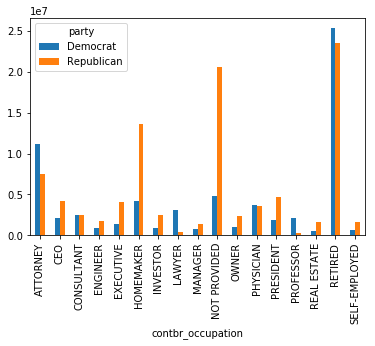

In [65]:
over_2mm.plot(kind='bar')

### 由于 Obama和Romney是最主要的两名候选人，我们专门用一个子集，只包含针对他们两个人的赞助信息

In [66]:
fec_mrbo = fec[fec['cand_nm'].isin(['Obama, Barack','Romney, Mitt'])]

### 我们接下来了解一下对Obama和Romney总出资最高的职业和企业，为此，我们先对候选人进行分组，然后通过分组函数选出出资最高

In [68]:
def get_top_amounts(group,key,n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.sort_values(ascending=False)[:n]

In [72]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts,'contbr_occupation',n=7)

cand_nm        contbr_occupation
Obama, Barack  RETIRED              25305116.38
               ATTORNEY             11141982.97
               NOT PROVIDED          4866973.96
               HOMEMAKER             4248875.80
               PHYSICIAN             3735124.94
               LAWYER                3160478.87
               CONSULTANT            2459912.71
Romney, Mitt   RETIRED              11508473.59
               NOT PROVIDED         11396894.84
               HOMEMAKER             8147446.22
               ATTORNEY              5364718.82
               PRESIDENT             2491244.89
               CEO                   2324297.03
               EXECUTIVE             2300947.03
Name: contb_receipt_amt, dtype: float64

从数据可以看出，Obama更受精英群体（律师、医生、咨询顾问）的欢迎，Romney则得到更多企业家或企业高管的支持

In [74]:
grouped.apply(get_top_amounts,'contbr_employer',n=10)

cand_nm        contbr_employer   
Obama, Barack  RETIRED               22694358.85
               SELF-EMPLOYED         18626807.16
               NOT EMPLOYED           8586308.70
               NOT PROVIDED           5053480.37
               HOMEMAKER              2605408.54
               STUDENT                 318831.45
               VOLUNTEER               257104.00
               MICROSOFT               215585.36
               SIDLEY AUSTIN LLP       168254.00
               REFUSED                 149516.07
Romney, Mitt   NOT PROVIDED          12059527.24
               RETIRED               11506225.71
               HOMEMAKER              8147196.22
               SELF-EMPLOYED          7414115.22
               STUDENT                 496490.94
               CREDIT SUISSE           281150.00
               MORGAN STANLEY          267266.00
               GOLDMAN SACH & CO.      238250.00
               BARCLAYS CAPITAL        162750.00
               H.I.G. CAPITAL      

Obama：微软、盛德国际律师事务所；    Romney：瑞士瑞信银行、摩根斯坦利、高盛公司、巴克莱资本、H.I.G.资本

## 对出资分组

还可以对该数据做另一种非常实用的分析：利用cut函数根据出资额大小将数据离散化到多个面元中：

In [75]:
bins = np.array([0,1,10,100,1000,10000,100000,1000000,10000000])
labels = pd.cut(fec_mrbo['contb_receipt_amt'],bins)
labels

411           (10, 100]
412         (100, 1000]
413         (100, 1000]
414           (10, 100]
415           (10, 100]
416           (10, 100]
417         (100, 1000]
418           (10, 100]
419         (100, 1000]
420           (10, 100]
421           (10, 100]
422         (100, 1000]
423         (100, 1000]
424         (100, 1000]
425         (100, 1000]
426         (100, 1000]
427       (1000, 10000]
428         (100, 1000]
429         (100, 1000]
430           (10, 100]
431       (1000, 10000]
432         (100, 1000]
433         (100, 1000]
434         (100, 1000]
435         (100, 1000]
436         (100, 1000]
437           (10, 100]
438         (100, 1000]
439         (100, 1000]
440           (10, 100]
              ...      
701356        (10, 100]
701357          (1, 10]
701358        (10, 100]
701359        (10, 100]
701360        (10, 100]
701361        (10, 100]
701362      (100, 1000]
701363        (10, 100]
701364        (10, 100]
701365        (10, 100]
701366        (1

In [81]:
grouped_bins = fec_mrbo.groupby(['cand_nm',labels])
#首先统计各出资区间的赞助笔数
grouped_bins.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


In [85]:
#再统计各区间的赞助金额
bucket_sums=grouped_bins['contb_receipt_amt'].sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [89]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1),axis=0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


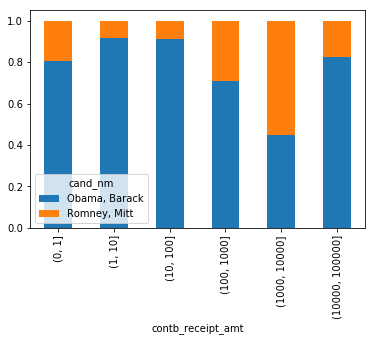

In [90]:
normed_sums[:-2].plot(kind='bar',stacked=True)

可以看出，小额赞助方面，Obama获得的数量和金额比Romney多得多

<img src="logo.jpg" style="width:100px;height:100px;float:right">